<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/14_09_22_FSH_Bed_Occupancy_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [41]:
data = pd.read_csv("/content/fsh_bed.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1461 non-null   object 
 1   occupancy  1461 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.0+ KB


In [43]:
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")
data.head(3)

,date,occupancy
0,2016-01-01,0.85
1,2016-01-02,0.88
2,2016-01-03,0.91


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1461 non-null   datetime64[ns]
 1   occupancy  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


In [45]:
data.tail(3)

,date,occupancy
1458,2019-12-29,0.87
1459,2019-12-30,0.80
1460,2019-12-31,0.71


In [48]:
# Renaming columns
#data = data.rename({'Day': 'date', 'Price in Dollars per Million Btu': 'gas_price'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [49]:
data.tail(3)

,occupancy
date,
2019-12-29,0.87
2019-12-30,0.80
2019-12-31,0.71


In [50]:
print(data.isnull().sum())

occupancy    0
dtype: int64


In [8]:
# There is one missing value in the data, we fill it with previous day's price.

data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [51]:
fig = px.line(data, title = 'FSH Bed Occupancy', template = 'plotly_dark')
fig.show()

In [52]:
fig = px.histogram(data, x = "occupancy", template = 'plotly_dark')
fig.show()

In [53]:
data = data.sort_values(by = 'date')

train = data['2016-01-01': '2019-06-30']  
test = data['2019-07-01': '2019-12-31'] 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  1277
Length of Test Data:  184


In [54]:
train.head(2)

,occupancy
date,
2016-01-01,0.85
2016-01-02,0.88


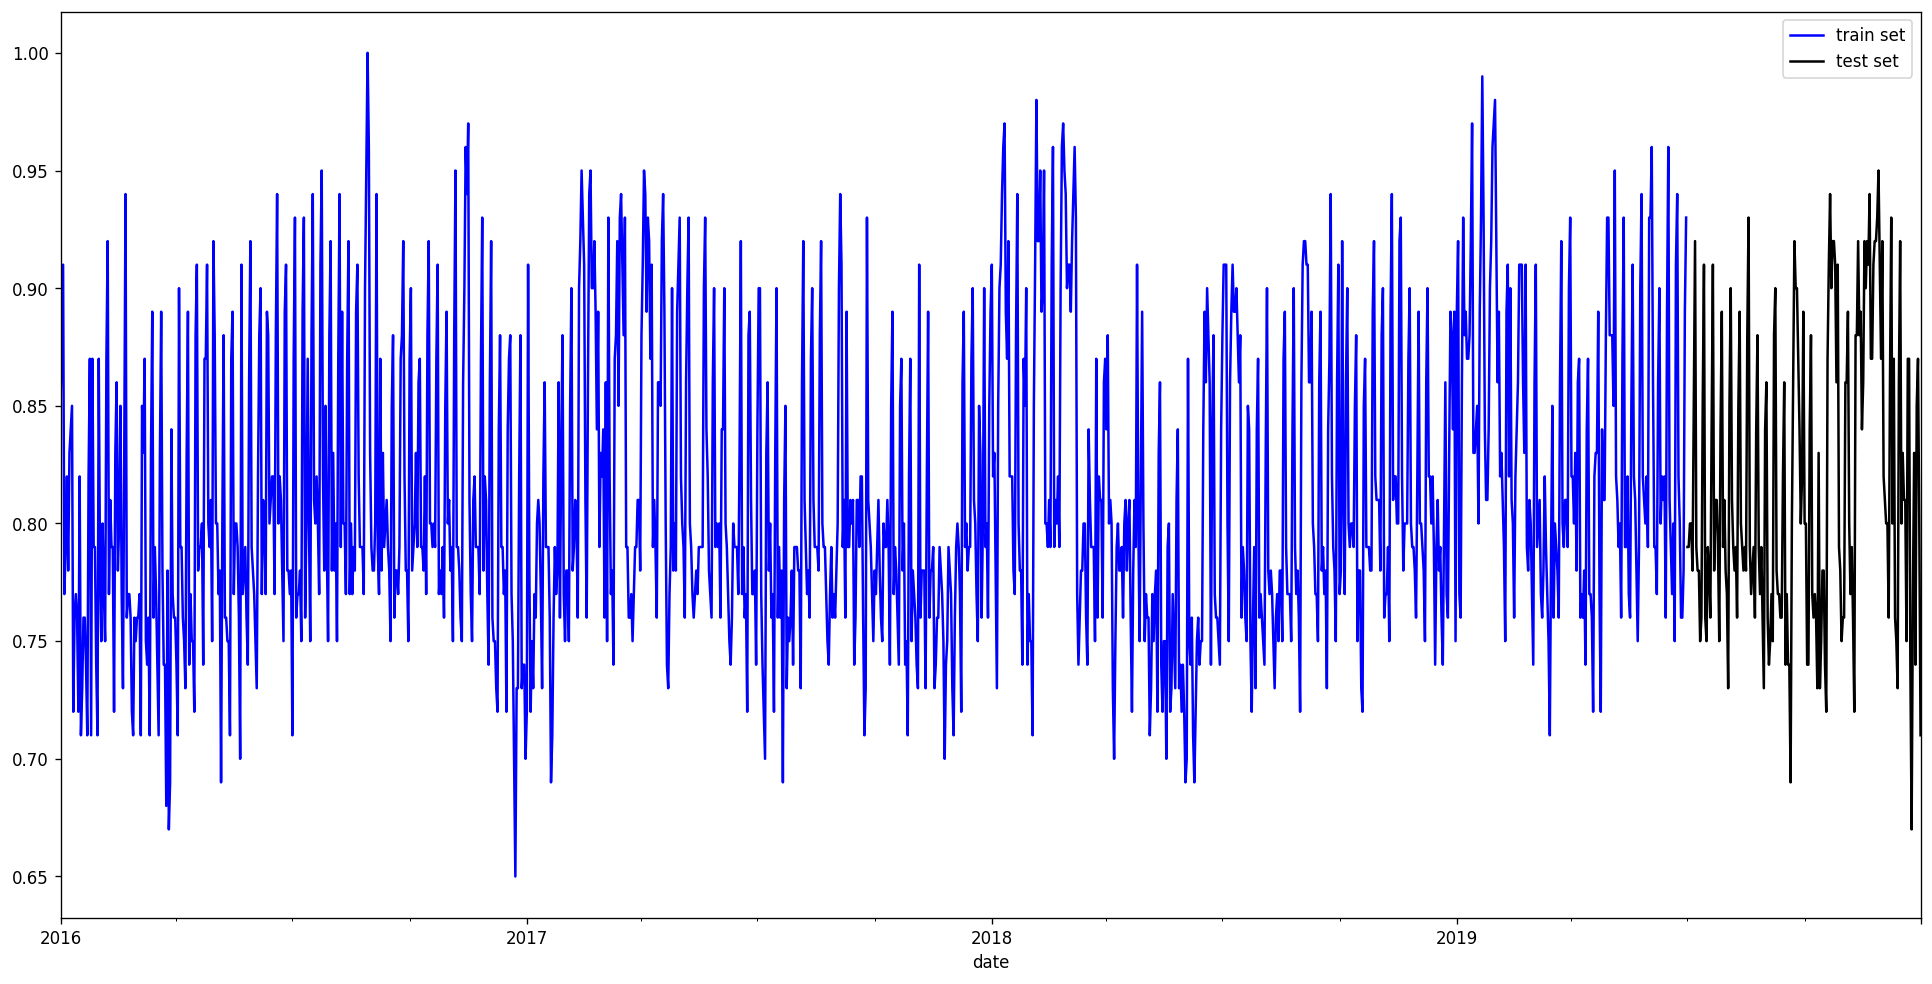

In [55]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

In [56]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit() 
print(arima_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              occupancy   No. Observations:                 1277
Model:                 ARIMA(1, 2, 1)   Log Likelihood                1711.323
Date:                Wed, 14 Sep 2022   AIC                          -3416.645
Time:                        00:35:56   BIC                          -3401.193
Sample:                    01-01-2016   HQIC                         -3410.842
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2042      0.032     -6.477      0.000      -0.266      -0.142
ma.L1         -1.0000      2.621     -0.382      0.703      -6.136       4.136
sigma2         0.0040      0.010      0.381      0.7

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [57]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1)) 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.00468320825138817

Test Data:
Mean Square Error: 0.012423665284908434


In [58]:
print(yp_test)

2016-01-01    0.000000
2016-01-02    1.275000
2016-01-03    0.910000
2016-01-04    0.940000
2016-01-05    0.770830
                ...   
2016-06-28    0.806191
2016-06-29    0.779494
2016-06-30    0.771483
2016-07-01    0.777446
2016-07-02    0.723414
Freq: D, Name: predicted_mean, Length: 184, dtype: float64


In [91]:
window_size = 60

x_train = []
y_train = []

for i in range(window_size, len(train)):
    x_train.append(train.iloc[i-window_size:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(1217, 60, 1) (1217,)


In [92]:
tf.keras.backend.clear_session()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(window_size, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(window_size, return_sequences=False),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mean_squared_error")

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 5)                 305       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 44,231
Trainable params: 44,231
Non-trainable params: 0
_________________________________________________________________


In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100, 
                         batch_size = 1, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/100
1217/1217 [==============================] - 41s 31ms/step - loss: 0.0073
Epoch 2/100
1217/1217 [==============================] - 48s 40ms/step - loss: 0.0047
Epoch 3/100
1217/1217 [==============================] - 47s 38ms/step - loss: 0.0043
Epoch 4/100
1217/1217 [==============================] - 44s 36ms/step - loss: 0.0038
Epoch 5/100
1217/1217 [==============================] - 49s 41ms/step - loss: 0.0034
Epoch 6/100
1217/1217 [==============================] - 45s 37ms/step - loss: 0.0032
Epoch 7/100
1217/1217 [==============================] - 48s 40ms/step - loss: 0.0031
Epoch 8/100
1217/1217 [==============================] - 44s 36ms/step - loss: 0.0031
Epoch 9/100
1217/1217 [==============================] - 43s 35ms/step - loss: 0.0030
Epoch 10/100
1217/1217 [==============================] - 55s 45ms/step - loss: 0.0031
Epoch 11/100
1217/1217 [==============================] - 45s 37ms/step - loss: 0.0029
Epoch 12/100
1217/1217 [============================

In [95]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'pred'}, inplace = True); 
a.index = train.iloc[window_size:].index
train_compare = pd.concat([train.iloc[window_size:], a], 1)

In [96]:
train_compare.head(3)

,occupancy,pred
date,,
2016-03-01,0.76,0.799017
2016-03-02,0.76,0.799182
2016-03-03,0.77,0.803622


In [97]:
train_compare.tail(3)

,occupancy,pred
date,,
2019-06-28,0.78,0.824027
2019-06-29,0.89,0.894437
2019-06-30,0.93,0.922501


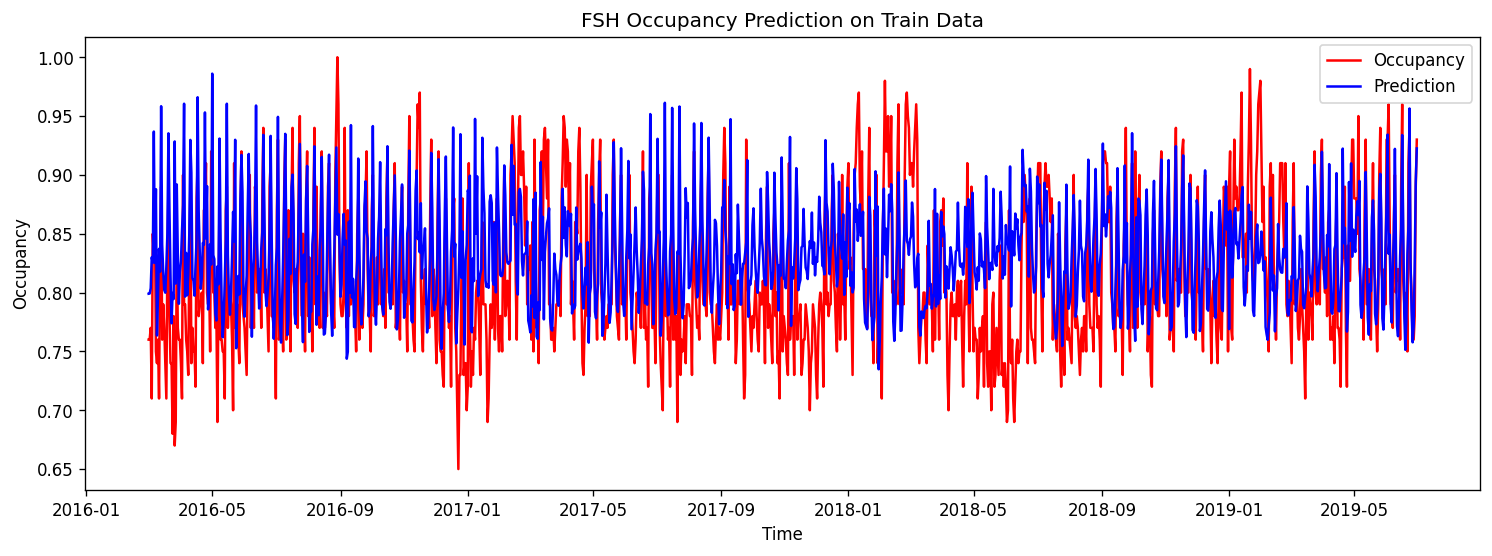

In [98]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['occupancy'], color = 'red', label = "Occupancy")
plt.plot(train_compare['pred'], color = 'blue', label = 'Prediction')
plt.title("FSH Occupancy Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend(loc = 'best')
plt.show()

In [99]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- window_size:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (window_size, len(test)+window_size): #Test+15
    x_test.append(inputs[i-window_size:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

In [100]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

In [101]:
test_compare.head(3)

,occupancy,pred
date,,
2019-07-01,0.79,0.846349
2019-07-02,0.79,0.759836
2019-07-03,0.80,0.752117


In [102]:
test_compare.tail(3)

,occupancy,pred
date,,
2019-12-29,0.87,0.889164
2019-12-30,0.80,0.817295
2019-12-31,0.71,0.790281


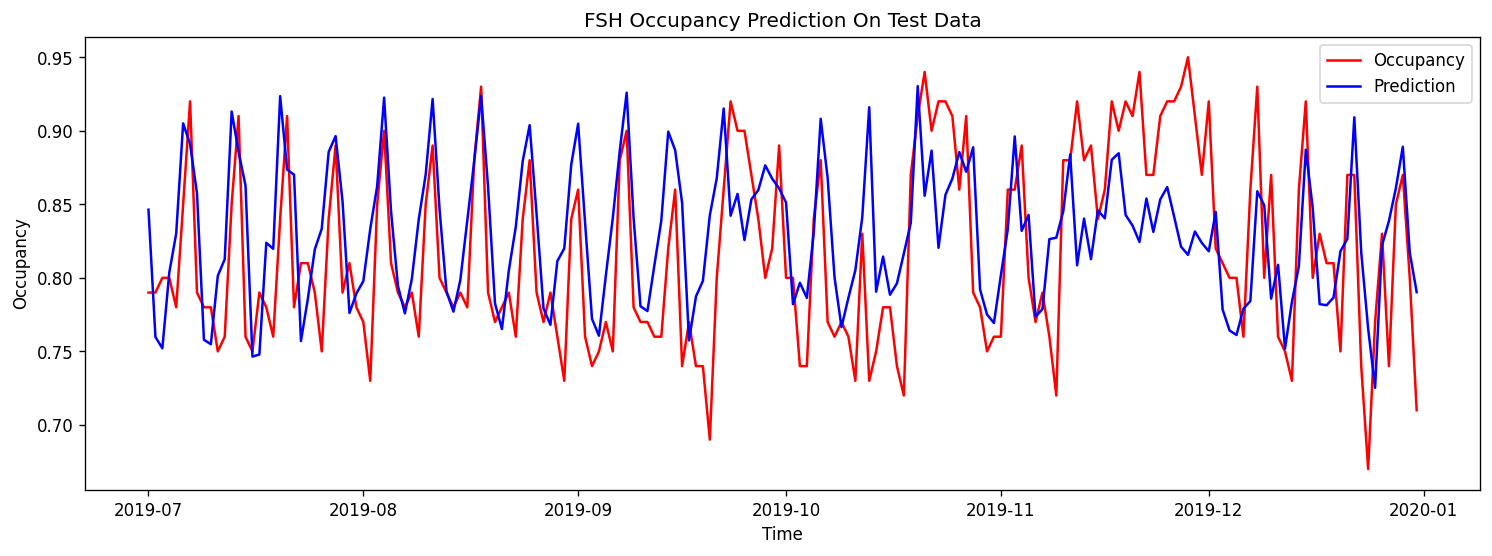

In [103]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['occupancy'], color = 'red', label = "Occupancy")
plt.plot(test_compare['pred'], color = 'blue', label = 'Prediction')
plt.title("FSH Occupancy Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend(loc = 'best')
plt.show()

In [104]:
mse_train = mean_squared_error(train_compare['occupancy'], train_compare['pred'])
mse_test = mean_squared_error(test_compare['occupancy'], test_compare['pred'])

r2_train = r2_score(train_compare['occupancy'], train_compare['pred'])
r2_test = r2_score(test_compare['occupancy'], test_compare['pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.0037232863105018704
R Square: 0.05800548691227225

Test Data:
MSE: 0.0031545429462912574
R Square: 0.20505218145291482


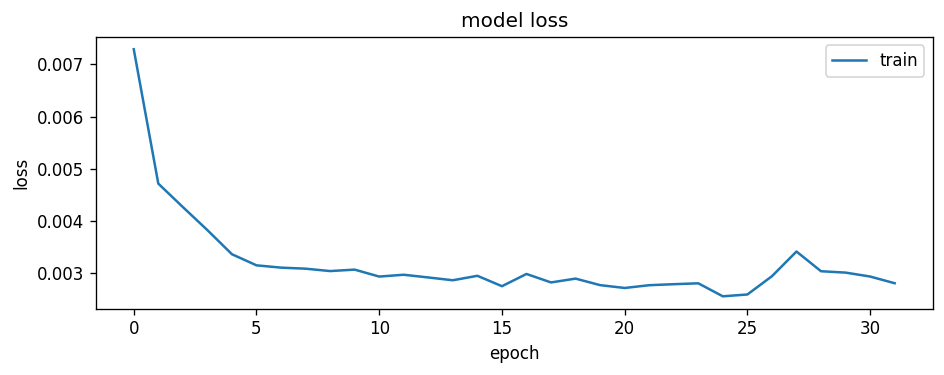

In [105]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [108]:
forecast = pd.DataFrame({'date': pd.date_range(start = '1/1/2020', end = '30/3/2020')}) 

inputs = test[len(test) - window_size: ].values

for i in range(window_size, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-window_size:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['pred'] = inputs
forecast = forecast.set_index('date')

In [109]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "pred", title = 'Occupancy Forecasting', template = 'plotly_dark')
fig.show()